In [1]:
import pandas as pd
df = pd.read_csv("/content/merged_dataset.csv")

In [2]:
x = df.drop(columns=["ddG"])
y = df["ddG"]

In [3]:
from sklearn.model_selection import train_test_split
categorical_features = ["name", "wt_seq", "mut_seq"]
numerical_faetures = [col for col in x.columns if col not in categorical_features]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [7]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_faetures),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

In [11]:
rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'wt_seq',
                                                   'mut_seq'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [12]:
y_pred = rf_pipeline.predict(x_test)

In [13]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

ValueError: Input contains NaN.

In [14]:
# Create a mask to identify rows with non-NaN values in y_test
non_nan_mask = ~y_test.isna()

# Filter both y_test and y_pred using the mask
y_test_filtered = y_test[non_nan_mask]
y_pred_filtered = y_pred[non_nan_mask]

print("MSE:", mean_squared_error(y_test_filtered, y_pred_filtered))
print("R2 Score:", r2_score(y_test_filtered, y_pred_filtered))

MSE: 95.419797253923
R2 Score: 0.6834410901891022


In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_features': ['sqrt', 'log2']
}

In [17]:
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

Best params: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 200}
Best CV R2: 0.654461148888551


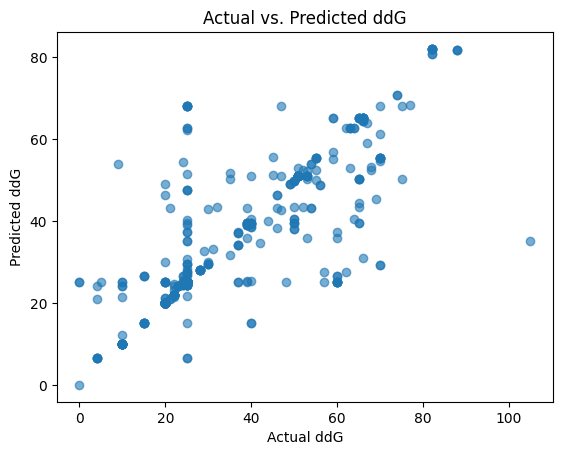

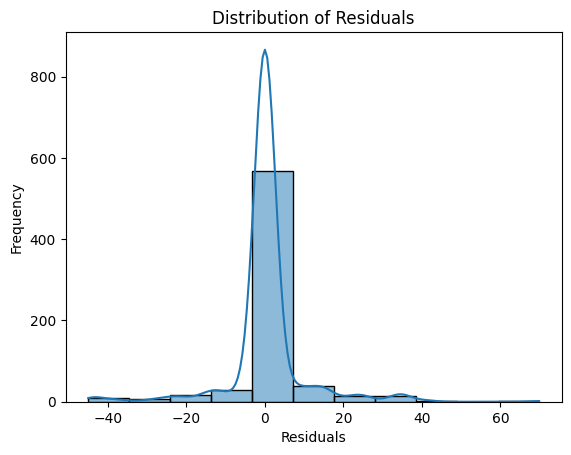

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual ddG")
plt.ylabel("Predicted ddG")
plt.title("Actual vs. Predicted ddG")
plt.show()

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [19]:
import numpy as np

feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

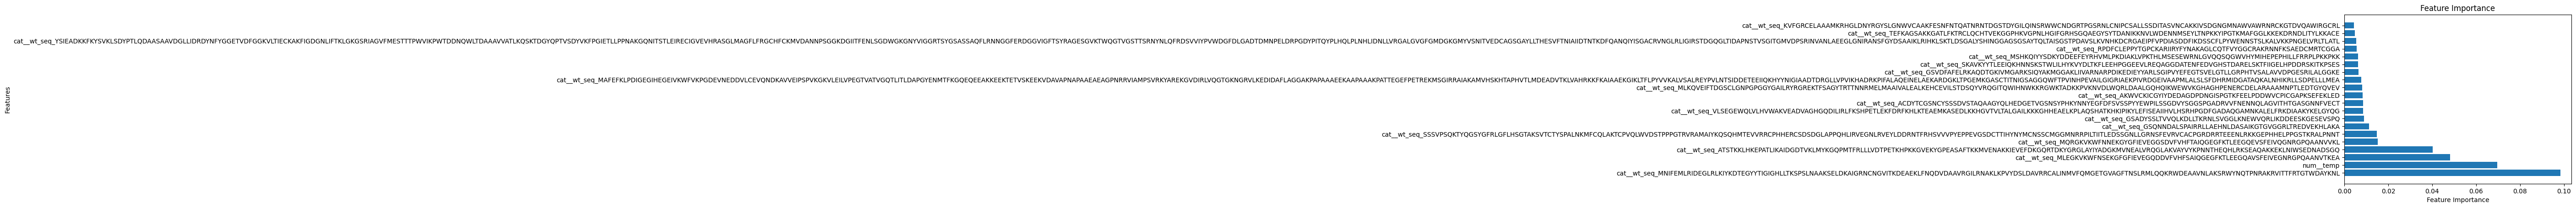

In [20]:
indices = np.argsort(feature_importances)[::-1][:20]
plt.barh(range(len(indices)), feature_importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

In [21]:
import joblib
joblib.dump(grid_search.best_estimator_, "rf_ddg_model.pkl")

['rf_ddg_model.pkl']

In [22]:
import joblib

joblib.load("rf_ddg_model.pkl")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['name', 'wt_seq',
                                                   'mut_seq'])])),
                ('regressor',
                 RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                       random_state=42))])

In [23]:
from google.colab import files
files.download("rf_ddg_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import joblib
import pandas as pd

In [25]:
model = joblib.load("rf_ddg_model.pkl")

In [26]:
test_data = pd.read_csv("/content/merged_dataset test set.csv")

In [31]:
test_data = test_data.drop(columns=['ddG'])

In [32]:
predictions = model.predict(test_data)

In [33]:
print(predictions[:10])

[46.93  40.165 40.165 40.165 40.165 40.165 40.165 40.165 40.165 40.165]


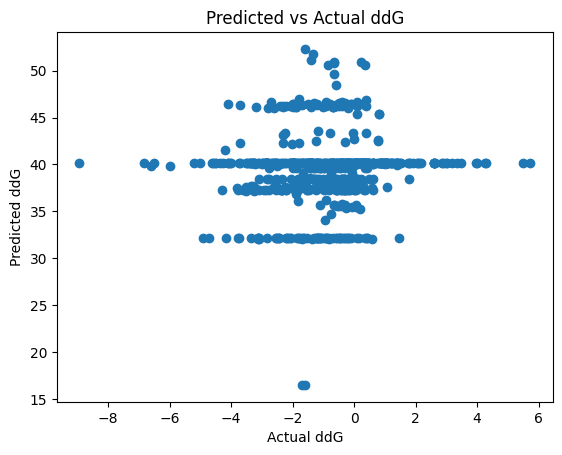

In [44]:
import matplotlib.pyplot as plt

plt.scatter(y_true, predictions)
plt.xlabel("Actual ddG")
plt.ylabel("Predicted ddG")
plt.title("Predicted vs Actual ddG")
plt.show()

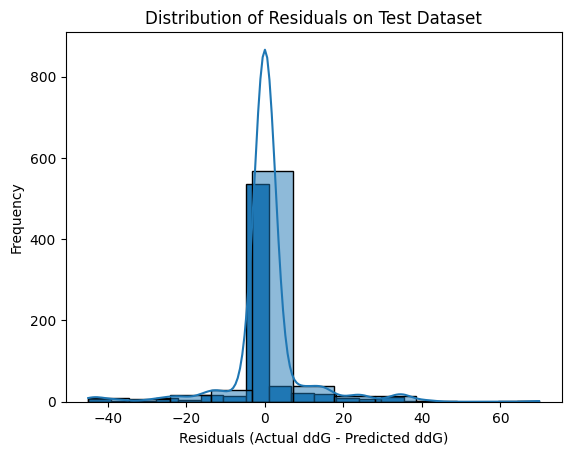

In [54]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=20, edgecolor='black')
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals (Actual ddG - Predicted ddG)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals on Test Dataset")
plt.show()

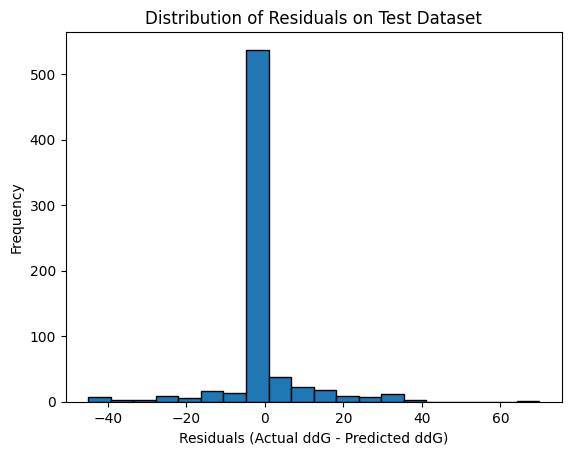

In [55]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel("Residuals (Actual ddG - Predicted ddG)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals on Test Dataset")
plt.show()

In [45]:
test_data["predicted_ddG"] = predictions
test_data.to_csv("/content/predictions.csv", index=False)

In [46]:
print("predicted_ddG_results.csv")

predicted_ddG_results.csv


In [48]:
from google.colab import files
files.download("predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>